#  First resnet implementation for kavisar -  PyTorch

In [24]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd # added to handle accuracy annd loss history

from sklearn.metrics import confusion_matrix
import itertools


plt.ion()   # interactive mode



In [25]:
data_dir = 'data_v2'
model_dir = data_dir + '/pytorch_models'
plot_dir  = data_dir + '/pytorch_plots'
history_dir = data_dir + '/pytorch_history'


model_name = '7_1_resnet18_kavisar__2018_07_17_v3_7'

accuracy_plot_name = 'accuracy_plot_' + model_name
loss_plot_name = 'loss_plot_' + model_name

number_of_epochs = 1

In [26]:
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [27]:
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [28]:
if not os.path.exists(history_dir):
    os.mkdir(history_dir)

In [29]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [30]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

In [31]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}

In [32]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
device.index

In [70]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=number_of_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history_df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        epoch_train_acc = 0
        epoch_train_loss = 0
        epoch_val_acc = 0
        epoch_val_loss = 0
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Collecting data for making plots
            if phase=='train':
                epoch_train_acc = epoch_acc
                epoch_train_loss = epoch_loss
            if phase=='validation':
                epoch_val_acc = epoch_acc
                epoch_val_loss =epoch_loss

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_df = pd.DataFrame([[epoch_train_acc.data,
                                 epoch_train_loss,
                                 epoch_val_acc.data,
                                 epoch_val_loss]],columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
        
        history_df = history_df.append(epoch_df,ignore_index=True)
        print()
        
    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history_df

In [71]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

In [72]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

 ## Multi GPU - Training

In [73]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model_ft = nn.DataParallel(model_ft)

In [74]:
model_ft = model_ft.to(device)

In [75]:
model_ft, df = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 1.2178 Acc: 0.5688
validation Loss: 0.5672 Acc: 0.7956

Training complete in 0m 29s
Best val Acc: 0.795625


In [76]:
torch.save(model_ft.state_dict(), os.path.join(model_dir,model_name))

In [77]:
df

,train_acc,train_loss,val_acc,val_loss
0,"tensor(0.5688, dtype=torch.float64, device='cu...",1.217807,"tensor(0.7956, dtype=torch.float64, device='cu...",0.567217


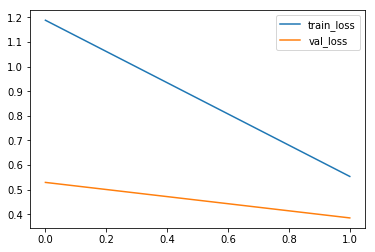

In [55]:
df.plot()

In [59]:
df

,train_acc,train_loss,val_acc,val_loss
0,"tensor(0.5737, dtype=torch.float64, device='cu...",1.188252,"tensor(0.8125, dtype=torch.float64, device='cu...",0.529685
1,"tensor(0.7846, dtype=torch.float64, device='cu...",0.553936,"tensor(0.8519, dtype=torch.float64, device='cu...",0.385468


In [64]:
df_loss = df[['train_loss','val_loss']]

In [65]:
df_loss

,train_loss,val_loss
0,1.188252,0.529685
1,0.553936,0.385468


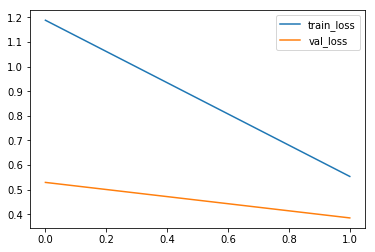

In [66]:
df_loss.plot()

In [67]:
df_acc = df[['train_acc','val_acc']]

In [68]:
df_acc.plot()

TypeError: Empty 'DataFrame': no numeric data to plot